In [99]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()

In [100]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        rnn_W = tf.Variable(tf.random_normal((size_layer * 2, output_size)))
        rnn_B = tf.Variable(tf.random_normal([output_size]))
        self.logits = tf.matmul(self.outputs[-1], rnn_W) + rnn_B
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
#         cc=(self.Y[:,0]+self.Y[:,1])/2
#         cc_logits=(self.logits[:,0]+self.logits[:,1])/2
#         rr=(self.Y[:,0]-self.Y[:,1])/2
#         rr_logits=(self.logits[:,0]-self.logits[:,1])/2
#         self.cost=tf.reduce_mean(tf.abs(cc-cc_logits)+tf.abs(rr-rr_logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )


In [101]:
df = pd.read_csv('../dataset/GOOGL-year.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-02,1127.420044,1131.300049,1111.170044,1119.199951,1119.199951,5892100
1,2018-02-05,1100.609985,1114.989990,1056.739990,1062.390015,1062.390015,4177500
2,2018-02-06,1033.979980,1087.380005,1030.010010,1084.430054,1084.430054,3831500
3,2018-02-07,1084.969971,1086.530029,1054.619995,1055.410034,1055.410034,2597100
4,2018-02-08,1059.869995,1063.930054,1004.700012,1007.710022,1007.710022,3339600


In [102]:
minmax = MinMaxScaler().fit(df.iloc[:, 2:4].astype('float32'))
df_select = minmax.transform(df.iloc[:, 2:4].astype('float32'))
df_select = pd.DataFrame(df_select)
df_log=pd.DataFrame(columns=['center','radius'])
df_log['center']=pd.Series((df_select.iloc[:,0].values+df_select.iloc[:,1].values)/2)
df_log['radius']=pd.Series((df_select.iloc[:,0].values-df_select.iloc[:,1].values)/2)
df_log.head()

,center,radius
0,0.447289,-0.020609
1,0.322715,0.045572
2,0.226453,0.042987
3,0.268055,-0.001658
4,0.140125,0.045361


In [103]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 400
dropout_rate = 0.6
future_day = 60

In [104]:
tf.reset_default_graph()
modelnn = Model(0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

E:\Anacoda3 REAL\lib\site-packages\tensorflow\python\client\session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [105]:
for i in range(epoch):
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df_log.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_log.shape[0] - 1)
        batch_x = np.expand_dims(
            df_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)


epoch: 100 avg loss: 0.0032155759539455177
epoch: 200 avg loss: 0.002986852974863723
epoch: 300 avg loss: 0.0031761393614578993
epoch: 400 avg loss: 0.001178139072144404


In [106]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0, :] = df_log.iloc[0, :]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_log.iloc[k : k + timestamp, :], axis = 0
            ),
            modelnn.backward_hidden_layer: init_value_backward,
            modelnn.forward_hidden_layer: init_value_forward,
        },
    )
    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    output_predict[k + 1 : k + timestamp + 1, :] = out_logits

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: np.expand_dims(df_log.iloc[upper_b:, :], axis = 0),
        modelnn.backward_hidden_layer: init_value_backward,
        modelnn.forward_hidden_layer: init_value_forward,
    },
)
init_value_forward = last_state[0]
init_value_backward = last_state[1]
output_predict[upper_b + 1 : df_log.shape[0] + 1, :] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1, :]
date_ori.append(date_ori[-1] + timedelta(days = 1))


In [107]:
for i in range(future_day - 1):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:, :], axis = 0),
            modelnn.backward_hidden_layer: init_value_backward,
            modelnn.forward_hidden_layer: init_value_forward,
        },
    )
    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    output_predict[df_log.shape[0], :] = out_logits[-1, :]
    df_log.loc[df_log.shape[0]] = out_logits[-1, :]
    date_ori.append(date_ori[-1] + timedelta(days = 1))

In [108]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [109]:
df= pd.read_csv('../dataset/GOOGL-year-now.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-02,1127.420044,1131.300049,1111.170044,1119.199951,1119.199951,5892100
1,2018-02-05,1100.609985,1114.989990,1056.739990,1062.390015,1062.390015,4177500
2,2018-02-06,1033.979980,1087.380005,1030.010010,1084.430054,1084.430054,3831500
3,2018-02-07,1084.969971,1086.530029,1054.619995,1055.410034,1055.410034,2597100
4,2018-02-08,1059.869995,1063.930054,1004.700012,1007.710022,1007.710022,3339600


In [110]:
high_pre=df_log[:,0]+df_log[:,1]
low_pre=df_log[:,0]-df_log[:,1]
print(df_log[:,1])

[ 971.77928664  987.91855764  990.91625396  980.00604037  989.97471585
  987.33825013  977.34958913  968.53443861  971.08486134  973.23091717
  963.77850391  971.86449516  973.64377989  968.91981468  969.05436386
  978.76507804  968.03868647  968.32591917  982.21346436  980.02118563
  970.20339457  970.01163824  972.00271266  965.81251506  969.5029869
  967.59956217  979.81784978  970.49944996  970.15479113  973.16092694
  972.92428917  971.41771212  969.5564492   982.15315651  989.77561224
  984.05045639  985.32690904  982.22416214  980.97864975  984.42172253
  980.30100302  974.85047378  972.50636802  975.4394909   973.62978902
  978.1919581   963.06334109  965.16947293  967.88584031  965.39450674
  971.22343866  962.10460087  970.7263291   970.70847698  970.02331289
  969.33237632  967.17248986  979.06061124  964.22335659  963.79949766
  959.3589783   957.88276618  969.61183017  968.95327924  972.64795834
  976.92962387  973.4749955   968.77260654  963.59960744  962.15507621
  969.1

In [111]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

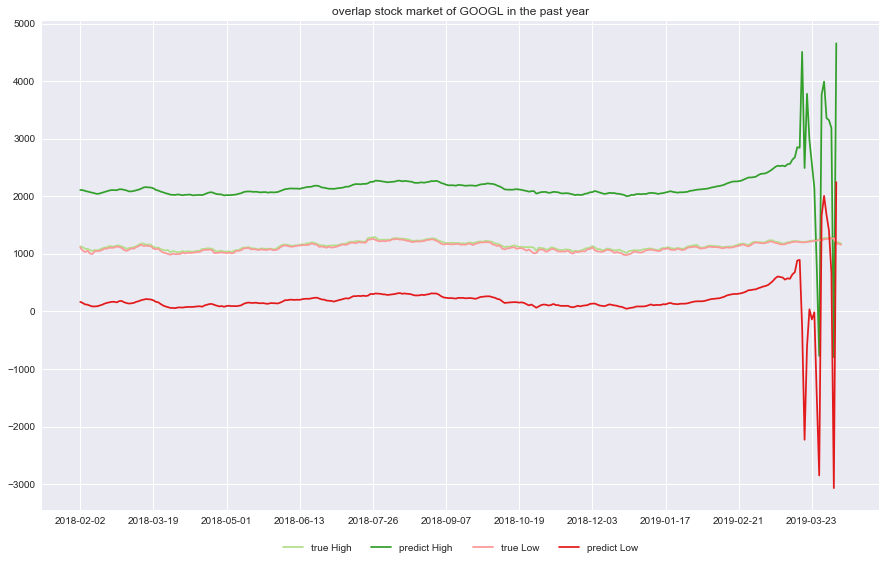

In [112]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(high_pre, 0.5),
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(low_pre, 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market of GOOGL in the past year')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


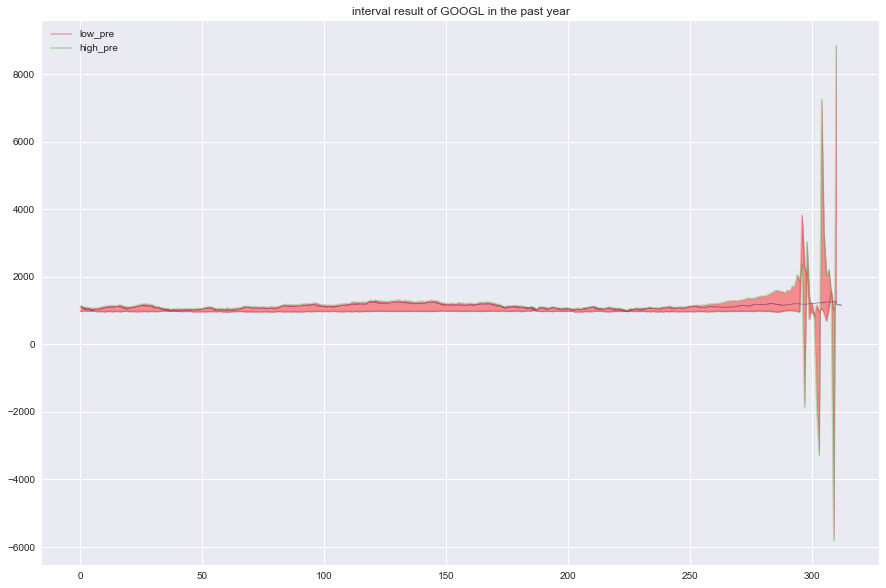

In [113]:
fig, ax = plt.subplots(figsize=(15,10))
# ax.plot(np.array(df.iloc[:,3]).reshape(-1), c=current_palette[4], label='low_origin',alpha=0.5)
# ax.plot(np.array(df.iloc[:,2]).reshape(-1), c=current_palette[2], label='high_origin',alpha=0.5)
print(type(df))
print(type(df_log))
ax.fill_between(range(len(df.iloc[:,3])), df.iloc[:,3], df.iloc[:,2], color='navy', alpha=0.4)
ax.plot(np.array(df_log[:,1]).reshape(-1), c=current_palette[5], label='low_pre',alpha=0.3)
ax.plot(np.array(df_log[:,0]).reshape(-1), c=current_palette[3], label='high_pre',alpha=0.3)
ax.fill_between(range(len(df_log[:,0])), df_log[:,1], df_log[:,0], color='red', alpha=.4)
ax.legend()
plt.title('interval result of GOOGL in the past year')
plt.show()